In [1]:
import keras
keras.__version__

Using TensorFlow backend.
/usr/local/anaconda3/envs/vecchio36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


'2.2.2'

In [2]:
%%bash 
echo "Current project structure:"
echo "==== root ==================="
ls ../../
echo "==== data ==================="
ls ../../data
echo "==== models ================="
ls ../../models
echo "==== Phase-1-Xception-0.0.0 ="
ls ../../models/Phase1-Xception-0.0.0/

Current project structure:
==== root ===================
AUTHORS.rst
CHANGELOG.rst
LICENSE.txt
README.rst
build
data
dev_requirements.txt
docs
models
requirements.txt
setup.cfg
setup.py
src
tests
tox.ini
==== data ===================
0Triclinic_Anorthite
1Hexagonal
2Cubic_FCC
3BCC
4Tetragonal
5PrimitiveCubic
==== models =================
Phase1-Xception-0.0.0
ResNet50Model-0.0.0
==== Phase-1-Xception-0.0.0 =
model_checkpoint.h5


## Approach 0: Visualizing intermediate Activations
This approach is useful to understand how each layer transforms its input. 

In [3]:
"""Define project path constants"""
import os
import pathlib as pl


ROOT = pl.Path('..' + os.sep + '..')
DATA = ROOT / 'data'
MODELS = ROOT /'models'
TARGET_MODEL = MODELS / 'Phase1-Xception-0.0.0' / 'model_checkpoint.h5'

In [4]:
"""Read in model"""
from keras.models import load_model

def open_model(model_path=TARGET_MODEL):
    return load_model(model_path)

model = open_model()

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 246, 299, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 122, 149, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 122, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 122, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [6]:
%%bash
ls ../../data/1Hexagonal/

WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0003.tiff
WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0011.tiff
WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0039.tiff
WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0040.tiff


In [7]:
img_path = DATA / '1Hexagonal' / 'WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0003.tiff'


import os

def get_img_in_dir(root): 
    files = os.listdir(str(root))
    
    return [str(root) + os.sep + f for f in files if str(f).endswith('.tiff')]

get_img_in_dir(DATA / '1Hexagonal')

['../../data/1Hexagonal/WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0003.tiff',
 '../../data/1Hexagonal/WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0039.tiff',
 '../../data/1Hexagonal/WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0040.tiff',
 '../../data/1Hexagonal/WC Hexagonal SPS Specimen 1 Site 5 Map Data 5_0011.tiff']

In [8]:
import sys
sys.path.insert(0, os.path.abspath('..'))

from vecchio.make_data import filename_to_img
import numpy as np

img_single = filename_to_img(img_path)
img_tensor = np.expand_dims(img_single, axis=0)

imgs = [filename_to_img(f) for f in get_img_in_dir(DATA / '1Hexagonal')]

The EBSD pattern is represented as a matrix of floats between 0 and 1. 
When we show it as an image, the relative intensity values will be
represented with a color map

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_grey_cmap(flat_img):
    plt.imshow(flat_img[:, :, 0], cmap=cm.Greys_r)
    plt.show()

def save_grey_cmap(flat_img):
    plt.imsave(flat_img[:, :, 0], cmap=cm.Greys_r)

plot_grey_cmap(img_single)

<Figure size 640x480 with 1 Axes>

In [10]:
import numpy as np

def make_3_channel_img(flat_img):
    img_rgb = np.zeros((*flat_img.shape[:2], 3))
    tmp = np.squeeze(flat_img)
    
    img_rgb[:, :, 0] = tmp
    img_rgb[:, :, 1] = tmp
    img_rgb[:, :, 2] = tmp
    
    return img_rgb



In [11]:
import vis
import vis.utils

ModuleNotFoundError: No module named 'vis.utils'; 'vis' is not a package

## Saliency Measure

In [19]:
import vis

from vis.utils import utils
from keras import activations

## Get the predictions layer index
layer_idx = utils.find_layer_idx(model, 'predictions')

## Swap softmax with linear layer
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

ModuleNotFoundError: No module named 'keras_vis'

In [ ]:
from vis.visualization import visualize_saliency, overlay

for modifier in ['guided', 'relu']:
    plt.figure()
    plt.suptitle(modifier)
    grads = visualize_saliency(model, layer_idx, 
                               filter_indices=1, 
                               seed_input=img_single,
                               backprop_modifier=modifier
                              )

    plt.imshow(grads, cmap='jet')

## grad-CAM: Vanilla, Guided, Rectified

In [ ]:
import numpy as np
import matplotlib.cm as cm
import vis
import vis.visualization
from vis.visualization import visualize_cam, overlay

def plot_gradcam(img, modifier='guided', title='', filter_idx=None):
    
    bg_rgb = make_3_channel_img(img)

    plot_title = title + ' ' + ('Vanilla' if modifier is None else modifier)
#     plt.suptitle(plot_title)
    grads = visualize_cam(model, -2, 
                          filter_indices=filter_idx,
                          seed_input=img,
                          backprop_modifier=modifier
                         )
    
    if np.isnan(grads).any():
        print('has NAN values')
    
    if np.isinf(grads).any():
        print('has INF values')
    
    no_null_grads = np.nan_to_num(grads)
    

    grads_in_img_range = np.clip(cm.jet(no_null_grads)[..., :3] * 255, 0, 255)
    
    # Overlay the heatmap onto original image.
    jet_heatmap = np.uint8(grads_in_img_range)
    no_null_heatmap = np.nan_to_num(jet_heatmap)
    
    
    plt.axes('off')
    to_show = overlay(no_null_heatmap, np.uint8(bg_rgb*255), alpha=0.5)
    plt.imshow(to_show)
    plt.imsave(to_show)
    
    
    plt.show()

def plot_cam_of_class(classdir='1Hexagonal', filter_idx=None):
    imgs = [filename_to_img(f) for f in get_img_in_dir(DATA / classdir)]
    for im in imgs:
        plt.figure()
        plot_gradcam(im, title=classdir, filter_idx=filter_idx)
        
plot_cam_of_class(filter_idx=1)

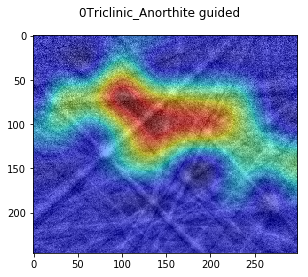

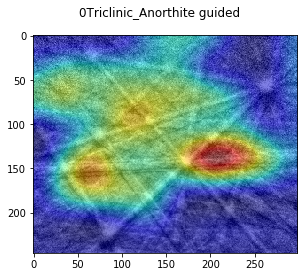

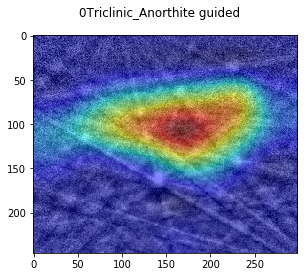

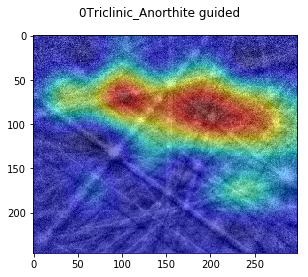

In [42]:
plot_cam_of_class('0Triclinic_Anorthite', 0)


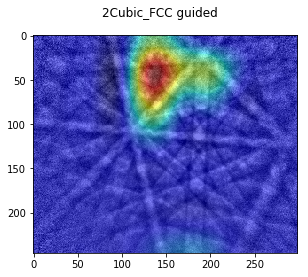

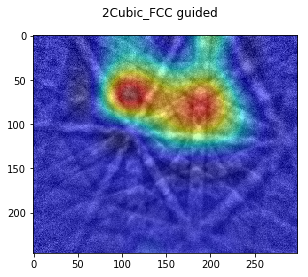

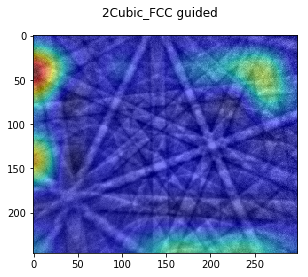

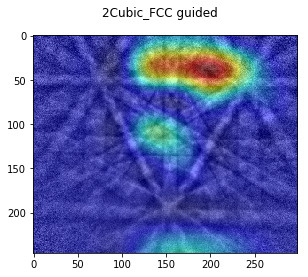

In [43]:
plot_cam_of_class('2Cubic_FCC', 2)


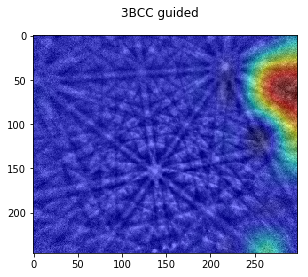

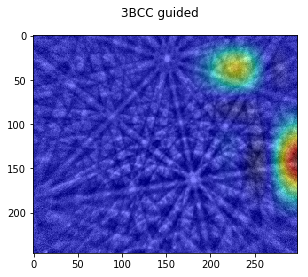

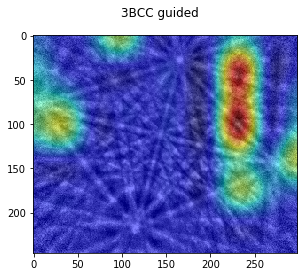

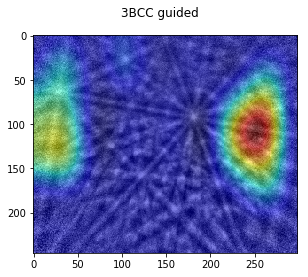

In [45]:
plot_cam_of_class('3BCC', 3)



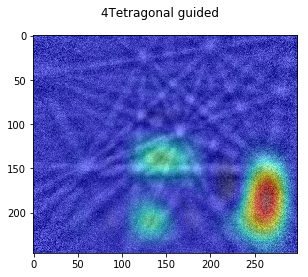

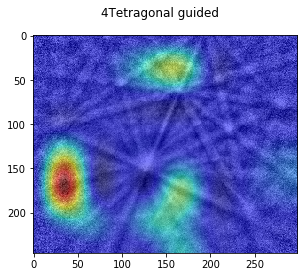

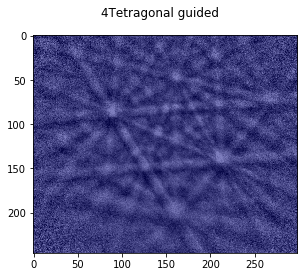

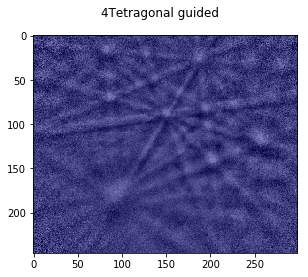

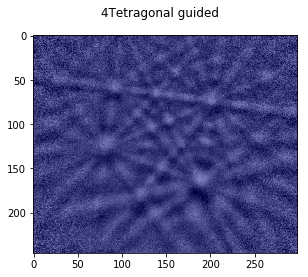

In [46]:
plot_cam_of_class('4Tetragonal', 4)

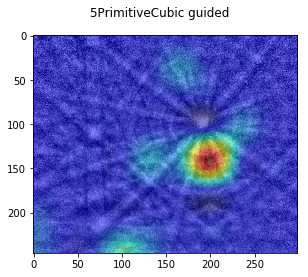

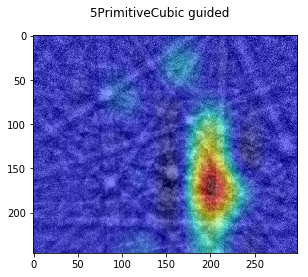

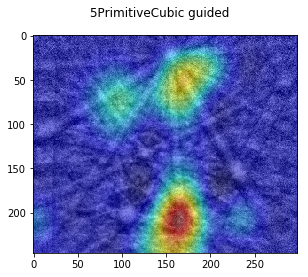

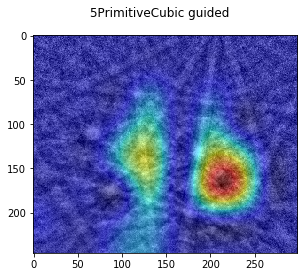

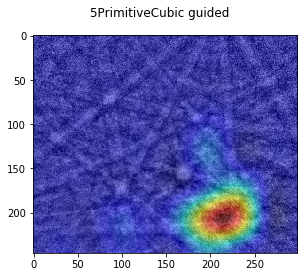

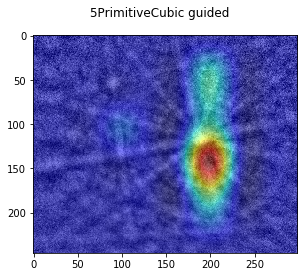

In [35]:
plot_cam_of_class('5PrimitiveCubic')


## Activation Maximiation
Example: https://github.com/raghakot/keras-vis/blob/master/examples/vggnet/activation_maximization.ipynb

In [6]:
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

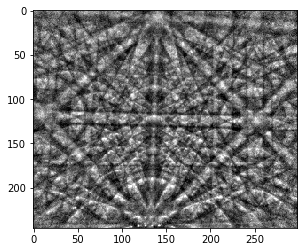

In [15]:
from vis.visualization import visualize_activation
from matplotlib import pyplot as plt

output_label_index = 1

img_act = visualize_activation(model, layer_idx, 
                           filter_indices=output_label_index)
img_act_rgb = make_3_channel_img(img_act)
plt.imshow(img_act_rgb)

plot_grey_cmap(img_act)

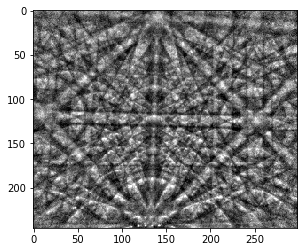

In [ ]:
"""
Don't run, will take a while to train

"""
img = visualize_activation(model, layer_idx, 
                           filter_indices=output_label_index, 
                           max_iter=500, verbose=True)
img make_3_channel_img(img)
plt.imshow(img)

## Visualizing Convolutional Filters


In [46]:
from vis.visualization import get_num_filters

def vis_conv_layers_by_name(layer_name):
    layer_idx = utils.find_layer_idx(model, layer_name)

    # Visualize all filters in this layer.
    filters = np.arange(get_num_filters(model.layers[layer_idx]))

    # Generate input image for each filter.
    vis_images = []
    for idx in filters:
        img_flat = visualize_activation(model, layer_idx, filter_indices=idx)

        img = make_3_channel_img(img_flat)

        img = np.uint8(img)
        # Utility to overlay text on image.
        img = utils.draw_text(img, 'Filter {}'.format(idx))

        vis_images.append(img)

    # Generate stitched image palette with 8 cols.
    stitched = utils.stitch_images(vis_images, cols=8)    
    plt.axis('off')
    plt.imshow(stitched)
    plt.title(layer_name)
    plt.show()

# vis_conv_layers_by_name('block1_conv1')

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed t

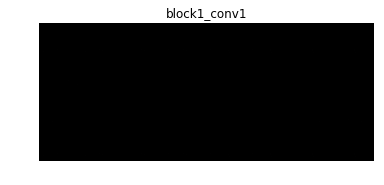

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed t

KeyboardInterrupt: 

In [47]:
for lname in ['block1_conv1', 'block1_conv2', 'conv2d_1', 'conv2d_2', 'conv2d_3']:
    vis_conv_layers_by_name(lname)

In [26]:
help(visualize_cam)

Help on function visualize_cam in module vis.visualization.saliency:

visualize_cam(model, layer_idx, filter_indices, seed_input, penultimate_layer_idx=None, backprop_modifier=None, grad_modifier=None)
    Generates a gradient based class activation map (grad-CAM) that maximizes the outputs of
    `filter_indices` in `layer_idx`.
    
    Args:
        model: The `keras.models.Model` instance. The model input shape must be: `(samples, channels, image_dims...)`
            if `image_data_format=channels_first` or `(samples, image_dims..., channels)` if
            `image_data_format=channels_last`.
        layer_idx: The layer index within `model.layers` whose filters needs to be visualized.
        filter_indices: filter indices within the layer to be maximized.
            If None, all filters are visualized. (Default value = None)
            For `keras.layers.Dense` layer, `filter_idx` is interpreted as the output index.
            If you are visualizing final `keras.layers.Dense` 